In [18]:
import agama
import astropy.units as u
import gala.dynamics as gd
import gala.potential as gp
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
from gala.units import galactic

agama.setUnits(length=u.kpc, mass=u.Msun, time=u.Myr)

I'm more used to the Gala interface for creating potential models, so for this example I make a Gala NFW model and then convert to Agama:

In [11]:
gala_pot = gp.NFWPotential.from_circular_velocity(
    v_c=240 * u.km / u.s, r_s=10 * u.kpc, units=galactic
)
agama_pot = gala_pot.as_interop("agama")

We don't need to generate samples from a self-consistent DF, so we can pick any density profile we want for the tracers we will sample. Here the "tracers" are the positions and velocities of the stream progenitors. We'll use a Dehnen (power law) model with a scale radius in kpc:

In [59]:
dens = agama.Density(type="Dehnen", scaleRadius=15)

For the DF (i.e. the energy distribution), we use a quasi-spherical, isotropic Osipkov-Merritt model:

In [60]:
df = agama.DistributionFunction(
    type="QuasiSpherical", potential=agama_pot, density=dens
)

In [30]:
gm = agama.GalaxyModel(agama_pot, df)

Generate 10,000 samples from this DF:

In [47]:
xv = gm.sample(10_000)[0]

The positions and velocities in what is returned are in 6-vectors with pos in kpc, vel in kpc/Myr. I have a class in Gala for interacting with phase-space coordinates like this:

In [48]:
w0 = gd.PhaseSpacePosition.from_w(xv.T, units=galactic)

Whenever I sample from a DF, I like to just verify that the samples succeeded. One check we can make is that if we integrate the orbits of the tracers, the distribution at the final orbital timestep looks the same as the initial distribution. I use Gala to do the orbit integration (`store_all=False` tells Gala not to store all of the intermediate timesteps, and it just integrates all of the orbits to the final time and returns that):

In [49]:
wf = gala_pot.integrate_orbit(
    w0, dt=0.5 * u.Myr, t1=0, t2=4 * u.Gyr, store_all=False
)[0]

Here we can check that the initial and final conditions are consisitent:

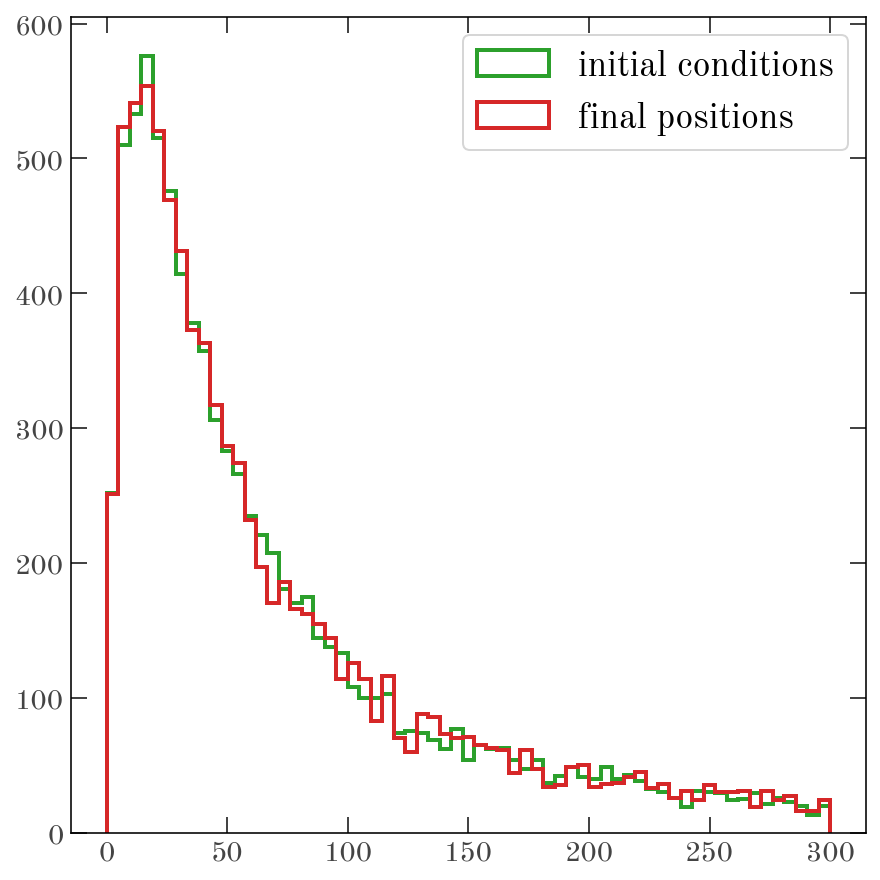

In [58]:
bins = np.linspace(0, 300, 64)
_ = plt.hist(
    w0.physicsspherical.r.value,
    bins=bins,
    histtype="step",
    color="tab:green",
    lw=2,
    label="initial conditions",
)
_ = plt.hist(
    wf.physicsspherical.r.value,
    bins=bins,
    histtype="step",
    color="tab:red",
    lw=2,
    label="final positions",
)
plt.legend(loc="best", fontsize=18)

When we chose a DF and start sampling, we'll probably want to decide on some truncation criteria to decide which streams to actually run. For example, a progenitor at 200 kpc that never gets close enough to strip is not worth simulating because it would never form a dense stream. We might want to require that the pericenter radius is < 10 kpc or something. A topic for us to discuss!